# Pair Programming 27/05 Regresión lineal múltiple I - Tatiana y Guada

In [21]:
# Importando módulos y cargando el dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )
import sidetable
import statsmodels.api as sm
import pylab as py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder # para realizar el Label Encoding 
from sklearn.preprocessing import OneHotEncoder  # para realizar el One-Hot Encoding

In [22]:
df = pd.read_csv("salary.csv")
df.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


# Ejercicio 1
Toma únicamente las variables de tipo numérico del dataset.
Realiza un EDA explicando algunas de las cosas interesantes del conjunto de datos

In [23]:
#Eliminamos la columna 'fnlwgt' puesto que en la descripción del dataset no es claro que valores incluye esta columna. 
df.drop(['fnlwgt'], axis = 'columns', inplace=True)

In [24]:
df_numeric = df.select_dtypes(include = ["float64","int64"])
df_numeric

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
...,...,...,...,...,...
32556,27,12,0,0,38
32557,40,9,0,0,40
32558,58,9,0,0,40
32559,22,9,0,0,20


In [25]:
df_numeric.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [26]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   education-num   32561 non-null  int64
 2   capital-gain    32561 non-null  int64
 3   capital-loss    32561 non-null  int64
 4   hours-per-week  32561 non-null  int64
dtypes: int64(5)
memory usage: 1.2 MB


In [27]:
df_numeric.isnull().sum()

age               0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64

In [28]:
df_numeric.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
education-num,32561,16,9,10501,1,51
age,32561,73,36,898,86,1
capital-loss,32561,92,0,31042,2201,1
hours-per-week,32561,94,40,15217,82,1
capital-gain,32561,119,0,29849,7978,1


In [29]:
df_numeric.stb.missing()

,missing,total,percent
age,0,32561,0.0
education-num,0,32561,0.0
capital-gain,0,32561,0.0
capital-loss,0,32561,0.0
hours-per-week,0,32561,0.0


In [30]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        
    return dicc_indices 

In [31]:
lista_columnas = list(['age', 'education-num', 'capital-loss','hours-per-week'])

ind = detectar_outliers(lista_columnas, df)
# vemos que es lo que nos ha devuelto la función
for key, values in ind.items():
    print('Para la variable ' + key  + ' tenemos ' + str(len(values)) +' valores outliers,  esto es un ' + str(round(len(values)/df.shape[0]*100)) + '%\ de los datos' )

Para la variable age tenemos 143 valores outliers,  esto es un 0%\ de los datos
Para la variable education-num tenemos 1198 valores outliers,  esto es un 4%\ de los datos
Para la variable capital-loss tenemos 1519 valores outliers,  esto es un 5%\ de los datos
Para la variable hours-per-week tenemos 9008 valores outliers,  esto es un 28%\ de los datos


Indagamos un poco más en la variable de hours-per-week puesto que hemos identificado muchos outliers

In [32]:
df["hours-per-week"].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
92        1
87        1
74        1
94        1
Name: hours-per-week, Length: 94, dtype: int64

In [33]:
# sacamos los valores de nuestro diccionario. 
valores = ind.values()
# hacemos una set comprehension para aplanar nuestra lista de listas y dejar un set. Puede ser que nos encontremos con índices que están repetidos, ya que puede ser que una fila tenga valores que sean outliers para dos columnas. 
## si recordamos de las primeras clases, en Python tenemos los sets que no permitían tener valores duplicados.

valores = {indice for sublista in valores for indice in sublista}

# nos hacemos una copia del dataframe original

df_numeric_sin_outliers = df.copy()

# eliminamos usando la lista de índices las filas que hemos identificado como outliers. 

df_numeric_sin_outliers = df_numeric_sin_outliers.drop(df_numeric_sin_outliers.index[list(valores)] )

print('Las dimensiones originales eran: ' + str(df.shape))
print('Las dimensiones sin outliers son: ' + str(df_numeric_sin_outliers.shape))

Las dimensiones originales eran: (32561, 14)
Las dimensiones sin outliers son: (21563, 14)


Obten la matriz de correlacion de las variables y estudia los resultados explicando las diferentes correlaciones con las variables.

<AxesSubplot:>

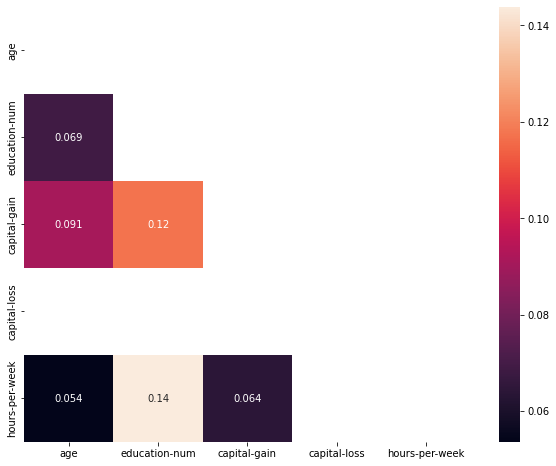

In [34]:
fig, ax = plt.subplots(figsize = (10,8))
corr = df_numeric_sin_outliers.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

        La correlacion está comprendido en el rango [+1 , -1]. Siendo +1 una correlación positiva perfecta y -1 una correlación negativa perfecta.

        Se emplean como medida de la fuerza de asociación entre dos variables (tamaño del efecto):

        0: asociación nula.

        0.1: asociación pequeña.

        0.3: asociación mediana.

        0.5: asociación moderada.

        0.7: asociación alta.

        0.9: asociación muy alta. 

        En nuestro dataset las variables que presentan asociación pequeña positiva son: educación num con Hours per week y Education num con Capital gain. 


Realiza el ajuste lineal múltiple mostrando las métricas.

In [35]:
df_numeric_sin_outliers.stb.missing()

,missing,total,percent
age,0,21563,0.0
workclass,0,21563,0.0
education,0,21563,0.0
education-num,0,21563,0.0
marital-status,0,21563,0.0
occupation,0,21563,0.0
relationship,0,21563,0.0
race,0,21563,0.0
sex,0,21563,0.0
capital-gain,0,21563,0.0


In [36]:
df_numeric_sin_outliers.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'salary'],
      dtype='object')

In [37]:
scaler = MinMaxScaler()
df_numeric_estandar = df_numeric_sin_outliers.copy()
df_numeric_estandar[['age', 'education-num', 'capital-loss','hours-per-week']] = scaler.fit_transform(df_numeric_estandar[['age', 'education-num', 'capital-loss','hours-per-week']])

In [44]:
x= df_numeric_estandar[['age', 'education-num', 'capital-loss',"hours-per-week"]] #independientes
y = df_numeric_estandar['capital-gain']#dependientes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresiónn lineal
LR = LinearRegression( normalize=True) # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.021958715154813624
El valor de r2 score adjusted es  0.021731857216896522
El MAE es 1915.064230148698
EL RMSE es  6706.3449530970975
Para el conjunto test:---------------
El valor de r2 score es  0.02380552999892227
El valor de r2 score adjusted es  0.022899128448317874
El MAE es 2089.3566415672253
EL RMSE es  7739.030224808847


/home/tnr1234/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


    Analizando los datos encontramos que nuestro modelo no es muy bueno puesto que:
    El valor R-cuadrado es menor a 0,3, consideranse un tamaño del efecto Ninguno o Muy débil. 
    El r2 ajustado es muy similar al r2 por lo tanto no es demasiado penalizado por el número de regresores
    El MAE y RMSE son elevado asi que tendremos que remediarlo. 
    Recordamos que, el MAE (Mean absolute error): Sirve para obtener una medida de la diferencia entre los valores predichos frete a los reales. Y nos indicará la precisión de la predicción obtenida. A menor MAE, mejor es capaz de ajustar los datos del modelo que hemos creado.
    RMSE (Root Mean Squared Error): Nos muestra la distancia promedio entre los valores predichos y los valores reales del dataset. A menor RMSE, mejor es capaz de ajustarse el modelo obtenido.




# Ejercicio 2
Toma ahora el dataset incluyendo las variables categóricas.
Realiza el EDA de las variables categóricas que se va a incluir en el modelo.

In [45]:
df_categoric = df.select_dtypes(include = "object")

In [46]:
df_categoric.describe()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [47]:
df_categoric.isnull().sum()

workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
salary            0
dtype: int64

    De las variables categoricas, seleccionamos salary, sex  y Workclass

In [48]:
for col in ["salary","sex","workclass"]:
    print("------------------------------------------------------------", "\n")
    print(f"En la columna {col} tenemos los siguientes valores unicos")
    print(df[col].unique())

------------------------------------------------------------ 

En la columna salary tenemos los siguientes valores unicos
[' <=50K' ' >50K']
------------------------------------------------------------ 

En la columna sex tenemos los siguientes valores unicos
[' Male' ' Female']
------------------------------------------------------------ 

En la columna workclass tenemos los siguientes valores unicos
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


In [49]:
lista_columnas = list(['age', 'education-num', 'capital-loss','hours-per-week'])
ind = detectar_outliers(lista_columnas, df)
valores = ind.values()
valores = {indice for sublista in valores for indice in sublista}
df_sin_outliers = df.copy()
df_sin_outliers = df_sin_outliers.drop(df_sin_outliers.index[list(valores)] ).reset_index(drop= True)
print('Las dimensiones originales eran: ' + str(df.shape))
print('Las dimensiones sin outliers son: ' + str(df_sin_outliers.shape))

Las dimensiones originales eran: (32561, 14)
Las dimensiones sin outliers son: (21563, 14)


Seleccionamos encoder para la variable de salario(es una variable de orden)

In [50]:
def ordinal_encoder1(df_sin_outliers, columna, orden_valores):
    
    # iniciamos el método y aplicamos la transformación a los datos. 
    ordinal = OrdinalEncoder(categories = [orden_valores], dtype = int)

    transformados_oe = ordinal.fit_transform(df[[columna]])
    
    # lo convertimos a dataframe
    oe_df = pd.DataFrame(transformados_oe)
    # cambiamos el nombre de la columna
    #oe_df.columns = ordinal.get_feature_names_in()
    
    # sobre escribimos la columna con los valores de la tranformación
    df_sin_outliers[columna] = oe_df
     
    return df

In [51]:
orden_salary = [' <=50K',' >50K']
ordenes = [orden_salary]
columnas_encode = ["salary"]
i = -1
for values in columnas_encode:
    i += 1
    ordinal_encoder1(df_sin_outliers,values,ordenes[i])

In [52]:
df_sin_outliers.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


Seleccionamos OneHotEncoder para la varible sex ya que no tiene orden

In [53]:
def one_hot_encoder_one(df_sin_outliers,columna,keep_first=True):
    
    # iniciamos el método de OneHot Encoder
    oh = OneHotEncoder()
    
    # hacemos la codificación de los datos para la variable dada 
    transformados = oh.fit_transform(df_sin_outliers[[columna]])
    
    # convertimos nuestro array con la codificación hecha en un dataframe
    oh_df = pd.DataFrame(transformados.toarray())
    
    # el método get_feature_names nos va a dar el nombre de las columnas nuevas que se nos generarán
    oh_df.columns = oh.get_feature_names()
    
    # concatenamos el dataframe original con el dataframe que acabamos de crear
    df_sin_outliers = pd.concat([df_sin_outliers,oh_df],axis=1)
    
    # eliminamos la columna original 
    df_sin_outliers.drop(columna, axis = 1,  inplace = True)
    return df_sin_outliers

In [54]:
columnas_encode = ["workclass"]
df_final =df_sin_outliers.copy()
for values in columnas_encode:

    df_final = one_hot_encoder_one(df_sin_outliers,values)

/home/tnr1234/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
df_final.head()

,age,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,...,salary,x0_ ?,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,x0_ Self-emp-inc,x0_ Self-emp-not-inc,x0_ State-gov,x0_ Without-pay
0,39,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,53,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,28,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,37,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [56]:
df_final.columns

Index(['age', 'education', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary', 'x0_ ?',
       'x0_ Federal-gov', 'x0_ Local-gov', 'x0_ Never-worked', 'x0_ Private',
       'x0_ Self-emp-inc', 'x0_ Self-emp-not-inc', 'x0_ State-gov',
       'x0_ Without-pay'],
      dtype='object')

Obten el ajuste lineal múltiple incluyendo las variables categóricas

In [57]:
x=df_final[["salary","education-num",'hours-per-week','x0_ ?','x0_ Federal-gov', 'x0_ Local-gov', 'x0_ Never-worked', 'x0_ Private','x0_ Self-emp-inc', 'x0_ Self-emp-not-inc', 'x0_ State-gov','x0_ Without-pay']]
y = df_final['capital-gain']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresiónn lineal
LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.02254539087877605
El valor de r2 score adjusted es  0.021864909628590112
El MAE es 1890.431569710574
EL RMSE es  6704.333258889465
Para el conjunto test:---------------
El valor de r2 score es  0.02562322752148083
El valor de r2 score adjusted es  0.02290403652851747
El MAE es 2040.2359621602563
EL RMSE es  7731.82173768036


# Ejercicio 3
Compara las métricas obtenidas del ajuste con las variables númerícas y con el modelo que incluia las variables categóricas. Explica los resultados obtenidos, pensando en posibles explicaciones.

Comparando el modelo de variables númericas con el de variables númericas y categoricas. No encontramos una variación significativa. El valor de r2 del modelo con las variables númerica es de 0.021 y el del modelo que incluye las variables categoricas tiene un r2 de 0.022. Para continuar con el análisis en los próximos pair seleccionamos el modelo con las variables númericas. 

In [58]:
df_final.to_csv("df_elegido.csv")